# ModelFireSizeDistributions

This notebook includes exploratory data analysis for modeling total fire size and duration based on a series of environmental variables.

The model we ended up fitting requires the following python packages: [`elapid`, `stemflow`, `scikit-learn`]. We used elapid version `1.0.1`, stemflow version `1.1`, and sklearn version `1.3.1`.

This notebook includes the following sections:

1. Packages and paths - specifying the packages we use and reading data into memory
2. Data cleaning - data preprocessing to properly format the data and toss outliers
3. Exploratory data analysis - simple data visualizations
4. Model 1: Geographic train/test split - an exploratory model to understand the ballpark prediction accuracy using gridded train/test splits
5. Model 2: AdaSTEM temporally-explicit modeling - a model that explicitly grids the data in spatial and temporal splits to fit localized relationships between covariates and target varaibles

The outputs from Model 2 are saved and uploaded to cloud storage for running predictions over larger areas.

## Section 1: Packages and paths

Specify the dependencies and read the data from cloud storage. There is a cell block at the end with `reload=True`. Set this to False if you want to re-run the operations set out in `Section 2: Data cleaning`.

In [1]:
# packages
import datetime as dt

import numpy as np
import pandas as pd
import elapid as ela
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn import ensemble, linear_model, metrics

from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMRegressor
from stemflow.model_selection import ST_CV, ST_train_test_split
from stemflow.utils.plot_gif import make_sample_gif

In [2]:
# paths
fod_path = "gs://earth-chris/fire-size/fod_with_predictors.gpkg"
mw_path = "gs://earth-chris/fire-size/mw-hull.gpkg"
cleaned_path = 'wildfire-ignition-generator/data/fod-cleaned.gpkg'

In [3]:
# data reads
reload = True
if reload:
    fod = gpd.read_file(cleaned_path)
    print('fod clean')
else:
    print('fod fpd')
    fod = gpd.read_file(fod_path)
    mw = gpd.read_file(mw_path)

fod clean


## Section 2: Data cleaning

These cells:

- drop unnecessary columns
- removes fires with no containment/end date
- clips the FOD data to the mountain west extent
- sets ignition and containment fields to `datetime` objects
- computes total fire duration
- creates a cyclic encoding of day of year (only consumed by model 1)

These cells don't need to be rerun if you are reloading the data from cloud storage.

In [6]:
fod.head()

,Acres,BI,ERC,WUI proximity,Pyrome,ignition_dt,containment_dt,fire_duration,ignition_sin,ignition_cos,geometry
0,35.0,72,70,8885.319336,1,2005-03-14 15:00:00,2005-03-15 14:00:00,0.958333,0.949990,0.312281,POINT (-11953444.045 4978171.928)
1,21.0,90,84,0.000000,1,2006-10-04 12:00:00,2006-10-13 15:00:00,9.125000,-0.999079,0.042905,POINT (-11880757.714 5413837.041)
2,13.0,97,96,182.482880,1,2007-08-02 18:00:00,2007-08-03 00:00:00,0.250000,-0.507415,-0.861702,POINT (-11808071.382 5230287.925)
3,10.0,94,79,0.000000,1,1995-06-27 14:00:00,1995-06-28 15:00:00,1.041667,0.085731,-0.996318,POINT (-11947252.841 5138162.508)
4,11.0,86,95,0.000000,1,1996-07-16 16:00:00,1996-07-17 09:00:00,0.708333,-0.254671,-0.967028,POINT (-11970731.17 5131598.794)


In [ ]:
# drop unused columns
fod = fod.drop(columns=['State', 'Name', 'MTBS ID', 'Longitude', 'Latitude'])

In [ ]:
# drop fires with no known containment date
no_containment = fod['Containment date'].isna()
fod = fod[~no_containment]

In [ ]:
# crop to the mountain west
fod = gpd.overlay(fod, mw.to_crs(fod.crs), how='intersection')

In [ ]:
# get the ignition time as a datetime
avg_ignition_time = np.nanmean(fod['Ignition time']) # this is imprecise; should do so with cyclic encoding, but; yolo
def ignition_datetime(row):
    month, day, year = str(row['Ignition date']).split('/')
    try:
        hour = int(row['Ignition time'] / 100)
    except ValueError:
        # NaN becomes dataset average
        hour = int(avg_ignition_time / 100)
    ignition_dt = dt.datetime(year=int(year), month=int(month), day=int(day), hour=hour)
    return ignition_dt

fod['ignition_dt'] = fod.apply(lambda row : ignition_datetime(row), axis=1)

In [ ]:
# get containment time as a datetime
avg_containment_time = np.nanmean(fod['Containment time'])
def containment_datetime(row):
    month, day, year = str(row['Containment date']).split('/')
    try:
        hour = int(row['Containment time'] / 100)
    except ValueError:
        # NaN becomes dataset average
        hour = int(avg_containment_time / 100)
    containment_dt = dt.datetime(year=int(year), month=int(month), day=int(day), hour=hour)
    return containment_dt

fod['containment_dt'] = fod.apply(lambda row : containment_datetime(row), axis=1)

In [ ]:
# compute the time between ignition and containment in fractional days
def compute_duration(row):
    difference = row['containment_dt'] - row['ignition_dt']
    return difference.total_seconds() / dt.timedelta(days=1).total_seconds()

fod['fire_duration'] = fod.apply(lambda row: compute_duration(row), axis=1)

In [ ]:
# compute the ignition date as cyclically encoded variables
def date_sin(row):
    sin = np.sin(2 * np.pi * row['ignition_dt'].timetuple().tm_yday/366.)
    return sin

def date_cos(row):
    cos = np.cos(2 * np.pi * row['ignition_dt'].timetuple().tm_yday/366.)
    return cos

fod['ignition_sin'] = fod.apply(lambda row: date_sin(row), axis=1)
fod['ignition_cos'] = fod.apply(lambda row: date_cos(row), axis=1)

In [ ]:
# add x/y columns from the geometry
fod['x'] = [row.geometry.centroid.x for _, row in fod.iterrows()]
fod['y'] = [row.geometry.centroid.y for _, row in fod.iterrows()]

In [ ]:
# drop the original date columns
fod = fod.drop(columns=['Ignition date', 'Ignition time', 'Containment date', 'Containment time'])

In [ ]:
# save the file locally for faster future i/o
fod.to_file('fod-cleaned.gpkg', driver='GPKG')

# this got uploaded to cloud storage via $ gsutil cp fod-cleaned.gpkg gs://earth-chris/fire-size/

## Section 3: Exploratory data analysis

These cells plot some very basic qualities of the data, and were used to develop some intuition for what we're modeling. You can mostly ignore them, but there is one cell at the bottom that tosses fires larger than ~100,000 acres (since we don't expect to be able to model these rare large fires using coarse climate data).

In [ ]:
fod['ignition_dt'].groupby(fod["ignition_dt"].dt.year).count().plot(kind="bar", title="Ignition count by year")

In [ ]:
fod['ignition_dt'].groupby(fod["ignition_dt"].dt.month).count().plot(kind="bar", title="Ignition count by month")

In [ ]:
fod[['ignition_dt', 'Acres', 'fire_duration']].groupby(fod["ignition_dt"].dt.month).mean().plot(y=['Acres', 'fire_duration'], subplots=True, kind="bar", title="Average monthly values")

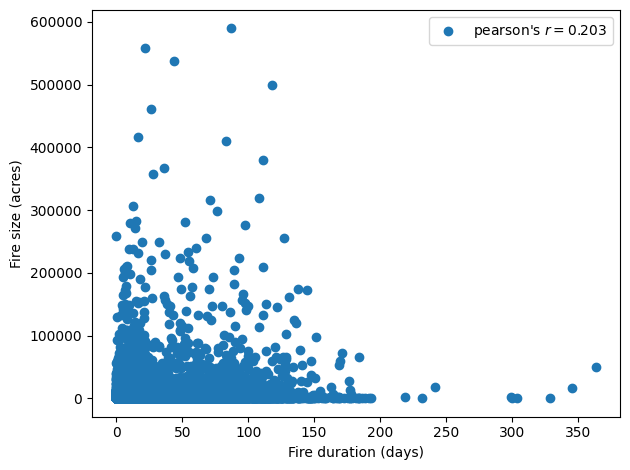

In [8]:
# relationship between fire size and duration
c = np.corrcoef(fod['fire_duration'], fod['Acres'])
pearsons_r = c[0,1]
plt.scatter(
    fod['fire_duration'],
    fod['Acres'],
    label=f"pearson's $r={pearsons_r:0.3f}$"
)
plt.xlabel("Fire duration (days)")
plt.ylabel("Fire size (acres)")
plt.legend()
plt.tight_layout()

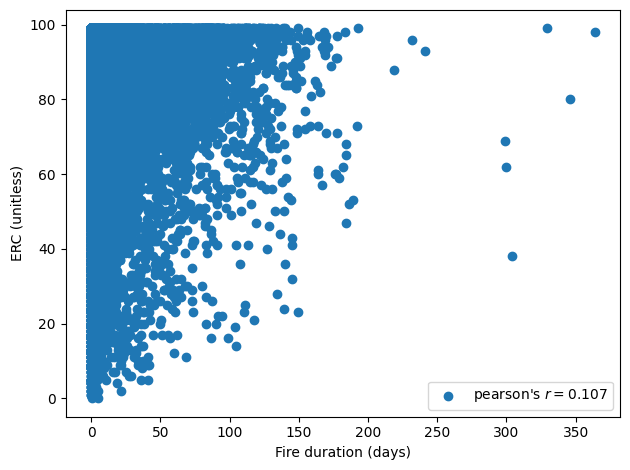

In [9]:
# relationship between ERC and duration
c = np.corrcoef(fod['fire_duration'], fod['ERC'])
pearsons_r = c[0,1]
plt.scatter(
    fod['fire_duration'],
    fod['ERC'],
    label=f"pearson's $r={pearsons_r:0.3f}$"
)
plt.xlabel("Fire duration (days)")
plt.ylabel("ERC (unitless)")
plt.legend()
plt.tight_layout()

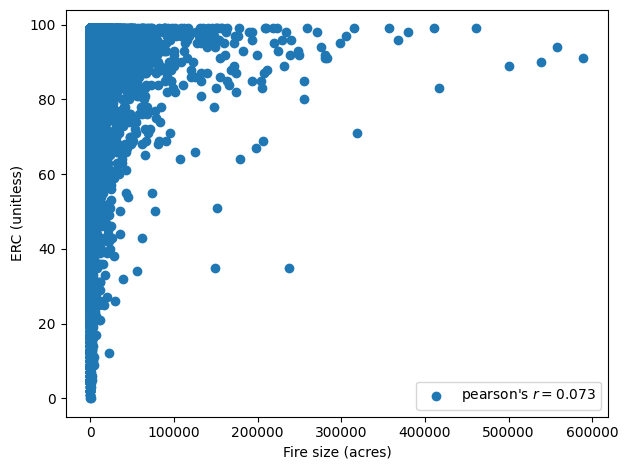

In [10]:
# relationship between ERC and size
c = np.corrcoef(fod['Acres'], fod['ERC'])
pearsons_r = c[0,1]
plt.scatter(
    fod['Acres'],
    fod['ERC'],
    label=f"pearson's $r={pearsons_r:0.3f}$"
)
plt.xlabel("Fire size (acres)")
plt.ylabel("ERC (unitless)")
plt.legend()
plt.tight_layout()

In [13]:
max_fire_size = np.percentile(fod['Acres'], 97.5)
valid = fod['Acres'] < max_fire_size
sub = fod[valid]

## Section 4: Model 1: Geographic train/test split

This model uses basic checkerboard splits to set up train/test data, and a gradient boosting regression model to predict fire size and fire duration. It uses the following covariates: `["doy", "x", "y", "BI", "ERC", "WUI proximity", "Pyrome"]`. There was some experimentation with different time and space attributes, but they don't seem to have made much difference.

The conclusions I drew from this work were:

- Spatially and temporally-explicit covariates (x/y/doy/pyrome) had the most explanatory power
- We can explain some amount of the expected fire duration (r2 ~0.25)
- We cannot explain much of about expected fire size (r2 ~0.05)
- Overfitting is common (as diagnosed by large train/test splits)
- Adding additional features (like interaction terms between covariates) provided little additonal explanatory power
- Tree-based models perform better than linear models, and ensure that predictions are never < 0.

These cells do not need to be rerun, but should probably be kept around for posterity and for re-checking some things.

In [4]:
fod = gpd.read_file(cleaned_path)
fod.head()

,Acres,BI,ERC,WUI proximity,Pyrome,ignition_dt,containment_dt,fire_duration,ignition_sin,ignition_cos,geometry
0,35.0,72,70,8885.319336,1,2005-03-14 15:00:00,2005-03-15 14:00:00,0.958333,0.949990,0.312281,POINT (-11953444.045 4978171.928)
1,21.0,90,84,0.000000,1,2006-10-04 12:00:00,2006-10-13 15:00:00,9.125000,-0.999079,0.042905,POINT (-11880757.714 5413837.041)
2,13.0,97,96,182.482880,1,2007-08-02 18:00:00,2007-08-03 00:00:00,0.250000,-0.507415,-0.861702,POINT (-11808071.382 5230287.925)
3,10.0,94,79,0.000000,1,1995-06-27 14:00:00,1995-06-28 15:00:00,1.041667,0.085731,-0.996318,POINT (-11947252.841 5138162.508)
4,11.0,86,95,0.000000,1,1996-07-16 16:00:00,1996-07-17 09:00:00,0.708333,-0.254671,-0.967028,POINT (-11970731.17 5131598.794)


In [5]:
xcolumns = ["doy", "x", "y", "BI", "ERC", "WUI proximity", "Pyrome"]
x = fod[xcolumns]

KeyError: "['doy', 'x', 'y'] not in index"

In [14]:
# create a feature transformer
ft = ela.MaxentFeatureTransformer(feature_types=['linear', 'product'])
ft.fit(xtrain, categorical=['Pyrome'])
ft.transform(xtrain).shape


NameError: name 'xtrain' is not defined

In [ ]:
# use a 500 km grid size split
grid_size = 200_000
train, test = ela.checkerboard_split(sub, grid_size=grid_size)

# set the covariates to use
xcolumns = ["BI", "ERC", "WUI proximity", "Pyrome", "ignition_sin", "ignition_cos"]

# create feature-transformed data
ft = ela.MaxentFeatureTransformer(feature_types=['linear', 'product',  'hinge'], n_hinge_features=3)
xtrain = ft.fit_transform(train[xcolumns], categorical=['Pyrome'])
xtest = ft.transform(test[xcolumns])

# create the ydata
ytrain_size = train['Acres']
ytest_size = test['Acres']
ytrain_duration = train['fire_duration']
ytest_duration = test['fire_duration']

In [ ]:
# parameters
n_estimators = 200
max_depth = 3

print('fitting: fire size')
model_size = ensemble.GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth)
#model_size = linear_model.RidgeCV(fit_intercept=False)
model_size.fit(xtrain, ytrain_size)

print('fitting: fire duration')
model_duration = ensemble.GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth)
#model_duration = linear_model.RidgeCV(fit_intercept=False)
model_duration.fit(xtrain, ytrain_duration)

In [ ]:
# evaluation
ypred_size = model_size.predict(xtest)
ypred_duration = model_duration.predict(xtest)

r2_size = metrics.r2_score(ytest_size, ypred_size)
r2_duration = metrics.r2_score(ytest_duration, ypred_duration)

mae_size = metrics.mean_absolute_error(ytest_size, ypred_size)
mae_duration = metrics.mean_absolute_error(ytest_duration, ypred_duration)

print('--- fire size ---')
print(f'r2: {r2_size:0.3f} | MAE: {mae_size:0.3f}')
print('')

print('--- fire duration ---')
print(f'r2: {r2_duration:0.3f} | MAE: {mae_duration:0.3f}')

In [ ]:
plt.scatter(ytest_size, ypred_size)
plt.xlabel('yobs')
plt.ylabel('ypred')
plt.title('fire size')

In [ ]:
model_size.score(xtrain, ytrain_size)

In [ ]:
plt.scatter(ytest_duration, ypred_duration)
plt.xlabel('yobs')
plt.ylabel('ypred')
plt.title('fire duration')

## Section 5: Model 2: AdaSTEM temporally-explicit modeling

This section uses the [stemflow](https://github.com/chenyangkang/stemflow/tree/main) package to build spatio-temporally explicit regression models.

It creates an ensemble of different space/time grids for fitting localized model relationships using whatever regression model you choose. In this case, we have a dataframe with temporally-dynamic data on ERC/BI, as well as day-of-year, which supports fitting complex temporal relationships over different areas.

In [6]:
# data prep

# get day of year as a feature
def day_of_year(row):
    return int(row['ignition_dt'].timetuple().tm_yday)

fod['doy'] = fod.apply(lambda row: day_of_year(row), axis=1)

# convert x/y to lat/lon
def get_lon(row):
    return float(row.geometry.centroid.x)

def get_lat(row):
    return float(row.geometry.centroid.y)

# adastem expects x/y data in lat/lon
fod['x'] = fod.to_crs('EPSG:4326').apply(lambda row: get_lon(row), axis=1)
fod['y'] = fod.to_crs('EPSG:4326').apply(lambda row: get_lat(row), axis=1)

In [7]:
# set the covariates to use
xcolumns = ["doy", "x", "y", "BI", "ERC", "WUI proximity", "Pyrome"]
x = fod[xcolumns]

### Fire duration modeling - train/test split

In [14]:
xtrain

,doy,x,y,BI,ERC,WUI proximity,Pyrome
0,73,-123.887500,42.816944,72,70,8885.319336,1
1,277,-123.134167,47.634444,90,84,0.000000,1
2,214,-122.380833,45.555278,97,96,182.482880,1
3,178,-123.823333,44.540000,94,79,0.000000,1
5,212,-123.933333,43.860000,99,96,0.000000,1
...,...,...,...,...,...,...,...
53119,228,-111.122800,41.943300,78,99,5220.085938,128
53120,209,-109.015789,41.213600,94,95,3911.636230,128
53121,236,-106.892630,42.350470,92,91,0.000000,128
53122,249,-106.644011,41.831107,98,98,1508.674927,128


In [8]:
# model fitting for fire duration
y = fod['fire_duration'].values

# set the train/test splits
xtrain, xtest, ytrain, ytest = ST_train_test_split(
    x,
    y,
    Spatio1="x",
    Spatio2="y",
    Temporal1="doy",
    Spatio_blocks_count=50,
    Temporal_blocks_count=50,
    random_state=42,
    test_size=0.3
)

# model spec
model_duration = AdaSTEMRegressor(
    base_model=ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3),
    save_gridding_plot=False,
    ensemble_fold=10,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
    min_ensemble_required=1,                # Only points covered by > 1 ensemble will be predicted
    grid_len_upper_threshold=25,            # force splitting if the grid length exceeds 25
    grid_len_lower_threshold=5,             # stop splitting if the grid length fall short 5         
    temporal_start=1,                       # The next 4 params define the temporal sliding window
    temporal_end=366,                            
    temporal_step=31,                       # The window takes steps of 31 DOY (see AdaSTEM demo for details)
    temporal_bin_interval=61,               # Each window will contain data of 62 DOY
    points_lower_threshold=10,              # Only stixels with more than 10 samples are trained
    Spatio1='x',                            # The next three params define the name of 
    Spatio2='y',                            # spatiotemporal coordinates shown in the dataframe
    Temporal1='doy',
    use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
    njobs=5,
)
model_duration.fit(xtrain.reset_index(drop=True), ytrain, verbosity=2)

# save the results
ela.save_object(model_duration, 'fire-duration-model-preliminary.ela')

# model performance
ypred = model_duration.predict(xtrain)
valid = ~np.isnan(ypred)
r2 = metrics.r2_score(ytrain[valid], ypred[valid])
print(f'Train R2: {r2:0.3f}')

ypred = model_duration.predict(xtest)
valid = ~np.isnan(ypred)
r2 = metrics.r2_score(ytest[valid], ypred[valid])
print(f'Test R2 : {r2:0.3f}')

Generating Ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Training: 100%|██████████| 10/10 [01:16<00:00,  7.63s/it]


Train R2: 0.618
Test R2 : 0.272


In [10]:
print(fod.shape)
fod.head()

(53124, 14)


,Acres,BI,ERC,WUI proximity,Pyrome,ignition_dt,containment_dt,fire_duration,ignition_sin,ignition_cos,geometry,doy,x,y
0,35.0,72,70,8885.319336,1,2005-03-14 15:00:00,2005-03-15 14:00:00,0.958333,0.949990,0.312281,POINT (-11953444.045 4978171.928),73,-123.887500,42.816944
1,21.0,90,84,0.000000,1,2006-10-04 12:00:00,2006-10-13 15:00:00,9.125000,-0.999079,0.042905,POINT (-11880757.714 5413837.041),277,-123.134167,47.634444
2,13.0,97,96,182.482880,1,2007-08-02 18:00:00,2007-08-03 00:00:00,0.250000,-0.507415,-0.861702,POINT (-11808071.382 5230287.925),214,-122.380833,45.555278
3,10.0,94,79,0.000000,1,1995-06-27 14:00:00,1995-06-28 15:00:00,1.041667,0.085731,-0.996318,POINT (-11947252.841 5138162.508),178,-123.823333,44.540000
4,11.0,86,95,0.000000,1,1996-07-16 16:00:00,1996-07-17 09:00:00,0.708333,-0.254671,-0.967028,POINT (-11970731.17 5131598.794),198,-124.066667,44.468333


### Fire size modeling - train/test split

In [11]:
# model fitting for fire size
y = fod['Acres'].values

# set the train/test splits
xtrain, xtest, ytrain, ytest = ST_train_test_split(
    x,
    y,
    Spatio1="x",
    Spatio2="y",
    Temporal1="doy",
    Spatio_blocks_count=50,
    Temporal_blocks_count=50,
    random_state=42,
    test_size=0.3
)

In [30]:
xtrain

,doy,x,y,BI,ERC,WUI proximity,Pyrome
0,73,-123.887500,42.816944,72,70,8885.319336,1
1,277,-123.134167,47.634444,90,84,0.000000,1
2,214,-122.380833,45.555278,97,96,182.482880,1
3,178,-123.823333,44.540000,94,79,0.000000,1
5,212,-123.933333,43.860000,99,96,0.000000,1
...,...,...,...,...,...,...,...
53119,228,-111.122800,41.943300,78,99,5220.085938,128
53120,209,-109.015789,41.213600,94,95,3911.636230,128
53121,236,-106.892630,42.350470,92,91,0.000000,128
53122,249,-106.644011,41.831107,98,98,1508.674927,128


In [16]:
# model fitting
model_size = AdaSTEMRegressor(
    base_model=ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3),
    save_gridding_plot=False,
    ensemble_fold=10,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
    min_ensemble_required=1,                # Only points covered by > 1 ensemble will be predicted
    grid_len_upper_threshold=25,            # force splitting if the grid length exceeds 25
    grid_len_lower_threshold=5,             # stop splitting if the grid length fall short 5         
    temporal_start=1,                       # The next 4 params define the temporal sliding window
    temporal_end=366,                            
    temporal_step=31,                       # The window takes steps of 31 DOY (see AdaSTEM demo for details)
    temporal_bin_interval=61,               # Each window will contain data of 62 DOY
    points_lower_threshold=10,              # Only stixels with more than 10 samples are trained
    Spatio1='x',                            # The next three params define the name of 
    Spatio2='y',                            # spatiotemporal coordinates shown in the dataframe
    Temporal1='doy',
    use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
    njobs=5,
)
model_size.fit(xtrain.reset_index(drop=True), ytrain, verbosity=2)

# save the results
ela.save_object(model_duration, 'fire-size-model-preliminary.ela')

# model performance
ypred = model_size.predict(xtrain)
valid = ~np.isnan(ypred)
r2 = metrics.r2_score(ytrain[valid], ypred[valid])
print(f'Train R2: {r2:0.3f}')

ypred = model_size.predict(xtest)
valid = ~np.isnan(ypred)
r2 = metrics.r2_score(ytest[valid], ypred[valid])
print(f'Test R2 : {r2:0.3f}')

Training: 100%|██████████| 10/10 [01:17<00:00,  7.72s/it]


Train R2: 0.617
Test R2 : -0.049


In [41]:
import sys
import os 
import importlib


%load_ext autoreload
%autoreload
%reload_ext autoreload
import os
import shutil
import wandb
import torch

# Step 1: Clear Environment Variables
os.environ.pop('WANDB_API_KEY', None)

# Step 2: Clear Wandb Config Directory
wandb_config_dir = os.path.expanduser("~/.config/wandb")
if os.path.exists(wandb_config_dir):
    shutil.rmtree(wandb_config_dir)

import os
print("CUDA_VISIBLE_DEVICES:", os.environ.get('CUDA_VISIBLE_DEVICES'))

# Try to force PyTorch to see the GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

!nvidia-smi

print("PyTorch version:", torch.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda if torch.cuda.is_available() else "N/A")

# Print information about available GPUs
if torch.cuda.is_available():
    print("Number of GPUs:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available")

# Check if CUDA is initialized
print("Is CUDA initialized:", torch.cuda.is_initialized())

# If CUDA is available but not initialized, try to initialize it
if torch.cuda.is_available() and not torch.cuda.is_initialized():
    try:
        torch.cuda.init()
        print("CUDA initialized successfully")
    except Exception as e:
        print(f"Failed to initialize CUDA: {e}")

# Set the default tensor type to cuda if available
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("Default tensor type set to CUDA")
else:
    print("Using CPU tensors")

# Manually set the base path to your project root directory
BASE_PATH = '/teamspace/studios/this_studio/wildfire-ignition-generator'
sys.path.append(BASE_PATH)

# Add the 'src' directory to sys.path
src_path = os.path.join(BASE_PATH, 'src')
sys.path.append(src_path)

def reload_mods():

    %autoreload
    %load_ext autoreload
    %autoreload
    %reload_ext autoreload
    
    # Import your custom modules
    import src.data.geo_data_handler
    import src.data.preprocessor
    import src.models.normalizing_flow
    import src.models.cnf_utils

    # Reload the modules
    importlib.reload(src.data.preprocessor)
    importlib.reload(src.models.normalizing_flow)
    importlib.reload(src.models.cnf_utils)
    
    print("Modules reloaded successfully!")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA_VISIBLE_DEVICES: 0
Fri Jun 28 22:43:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:35:00.0 Off |                    0 |
| N/A   48C    P0              28W /  72W |    379MiB / 23034MiB |      0%      Default |
|                                         |   

In [27]:
xtrain

,doy,x,y,BI,ERC,WUI proximity,Pyrome
0,73,-123.887500,42.816944,72,70,8885.319336,1
1,277,-123.134167,47.634444,90,84,0.000000,1
2,214,-122.380833,45.555278,97,96,182.482880,1
3,178,-123.823333,44.540000,94,79,0.000000,1
5,212,-123.933333,43.860000,99,96,0.000000,1
...,...,...,...,...,...,...,...
53119,228,-111.122800,41.943300,78,99,5220.085938,128
53120,209,-109.015789,41.213600,94,95,3911.636230,128
53121,236,-106.892630,42.350470,92,91,0.000000,128
53122,249,-106.644011,41.831107,98,98,1508.674927,128


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules reloaded successfully!
Loading pyrome shapefile...
Pyrome shapefile loaded and indexed.


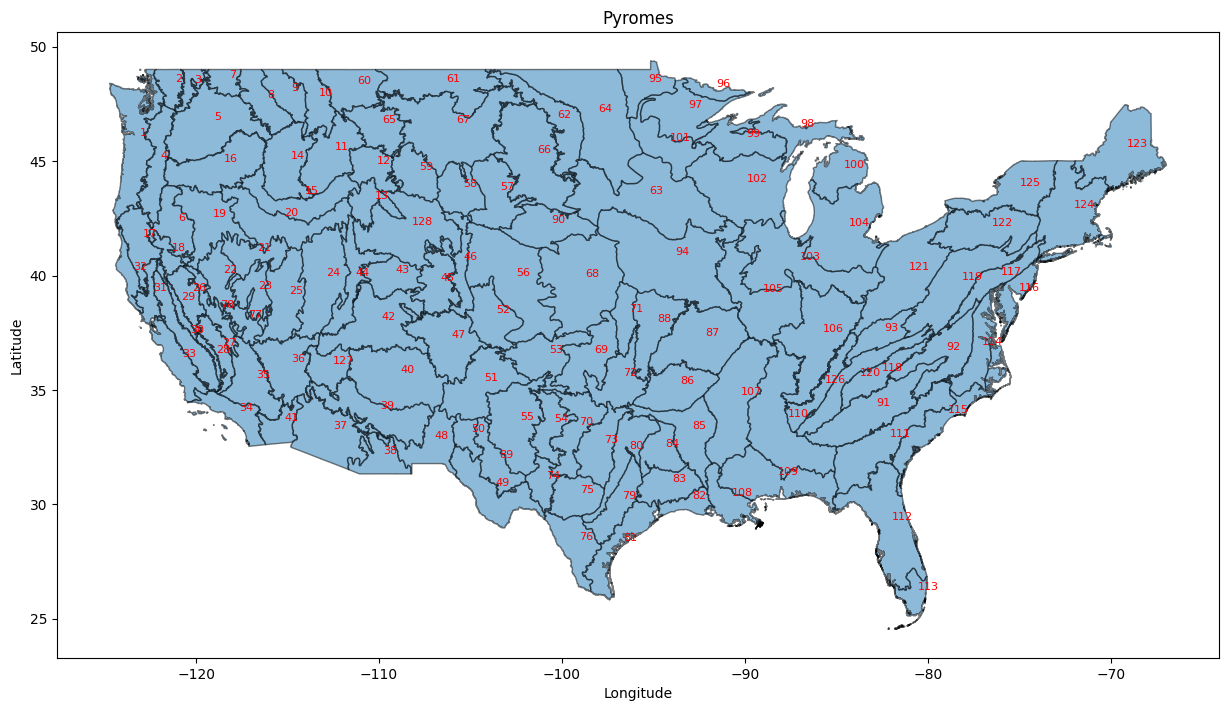

Loading NetCDF file: wildfire-ignition-generator/data/wildfire_indicators/raw_netcdfs/bi_2023.nc
Detected variable name for bi: burning_index_g
Loading NetCDF file: wildfire-ignition-generator/data/wildfire_indicators/raw_netcdfs/erc_2023.nc
Detected variable name for erc: energy_release_component-g
loaded
Using None processes for parallel execution.
finished
Processing data for day 181 of year 2023.
energy_release_component-g
Number of pixels: 810810
Image size (X, Y): (1385, 584)
Number of Rows to Process: (810810,)
Initial DataFrame created, starting parallel classification.
init df created
     Latitude  Longitude   ERC    BI  WUI proximity  X    Y
711      49.4 -95.141667  36.0  22.0            8.0  1  126
712      49.4 -95.100000  31.0  20.0            1.0  1  127
713      49.4 -95.058333  31.0  20.0            1.0  1  128
714      49.4 -95.016667  31.0  20.0            1.0  1  129
715      49.4 -94.975000  31.0  20.0            1.0  1  130
DataFrame shape after dropping NaN valu

In [42]:
reload_mods()
from src.data.preprocessor import WildfireDataProcessor
from src.models.normalizing_flow import ConditionalNormalizingFlow
from src.models.cnf_utils import CNFUtils, create_fire_size_range
from src.data.geo_data_handler import GeoDataHandler

import wandb
from datetime import datetime, timedelta
import numpy as np


data_dir = "wildfire-ignition-generator/data/wildfire_indicators/raw_netcdfs"
handler = GeoDataHandler(data_dir)
handler.load_netcdf_data("bi", 2023)
handler.load_netcdf_data("erc", 2023)

print('loaded')

handler.load_wui_data('placeholder_wui.tif')
daily_df = handler.get_daily_dataframe(datetime(2023, 7, 1))

In [37]:
daily_df['X']

2097         3
2098         3
2101         3
2102         3
3483         5
          ... 
807701    1380
807702    1380
807703    1380
807704    1380
807717    1380
Name: X, Length: 471313, dtype: int64

In [43]:
daily_df = daily_df.drop(columns=['X', 'Y'])

# Rename 'Latitude' and 'Longitude' to 'x' and 'y'
daily_df = daily_df.rename(columns={'Latitude': 'y', 'Longitude': 'x'})

# Drop the original 'x' and 'y' columns

# Convert 'Ignition date' to datetime
daily_df['Ignition date'] = pd.to_datetime(daily_df['Ignition date'])

# Define the day_of_year function
def day_of_year(row):
    return int(row['Ignition date'].timetuple().tm_yday)

# Apply the transformation to create the 'doy' column
daily_df['doy'] = daily_df.apply(lambda row: day_of_year(row), axis=1)
daily_df = daily_df.drop(columns=['Ignition date'])
new_order = ['doy', 'x', 'y', 'BI', 'ERC', 'WUI proximity', 'Pyrome']
daily_df = daily_df[new_order]
# Print the head of the resulting DataFrame


In [44]:
daily_df

,doy,x,y,BI,ERC,WUI proximity,Pyrome
2097,182,-95.141667,49.358333,21.0,35.0,9.0,95.0
2098,182,-95.100000,49.358333,22.0,36.0,9.0,95.0
2101,182,-94.975000,49.358333,22.0,37.0,9.0,95.0
2102,182,-94.933333,49.358333,23.0,38.0,10.0,95.0
3483,182,-95.141667,49.316667,22.0,36.0,8.0,95.0
...,...,...,...,...,...,...,...
807701,182,-81.058333,25.150000,0.0,7.0,23.0,113.0
807702,182,-81.016667,25.150000,0.0,6.0,24.0,113.0
807703,182,-80.975000,25.150000,0.0,9.0,24.0,113.0
807704,182,-80.933333,25.150000,0.0,9.0,24.0,113.0


In [45]:
ypred = model_size.predict(daily_df)
valid = ~np.isnan(ypred)

In [51]:
pyrome_shapefile_path = 'wildfire-ignition-generator/data/pyrome_shp/Pyromes_CONUS_20200206.shp'  # Replace with actual path


In [55]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from datetime import datetime
import os

# Assuming daily_df and ypred are already defined
valid = ~np.isnan(ypred)

# Create a DataFrame with the valid predictions
valid_pred_df = pd.DataFrame({'y_pred': ypred[valid]}, index=daily_df.index[valid])

# Merge valid predictions with daily_df
merged_df = daily_df.join(valid_pred_df)

# List of Pyromes to include
valid_pyromes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 
                 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 
                 58, 59, 60, 61, 62, 65, 67, 77, 78, 89, 127, 128]

# Filter merged_df to include only the specified Pyromes
merged_df = merged_df[merged_df['Pyrome'].isin(valid_pyromes)]

print("Merged DataFrame info:")
print(merged_df.info())
print("\nFirst few rows of merged_df:")
print(merged_df.head())
print(f"\nNumber of valid predictions: {len(merged_df)}")

# Create a GeoDataFrame from merged_df
gdf = gpd.GeoDataFrame(
    merged_df, geometry=gpd.points_from_xy(merged_df.x, merged_df.y), crs="EPSG:4326"
)

# Calculate the bounding box of the data
minx, miny, maxx, maxy = gdf.total_bounds

# Read the shapefile
pyrome_shapefile_path = 'wildfire-ignition-generator/data/pyrome_shp/Pyromes_CONUS_20200206.shp'  # Replace with actual path
pyrome_gdf = gpd.read_file(pyrome_shapefile_path)
pyrome_gdf = pyrome_gdf.to_crs(epsg=4326)

# Filter pyrome_gdf to include only the specified Pyromes
pyrome_gdf = pyrome_gdf[pyrome_gdf['PYROME'].isin(valid_pyromes)]

# Clip the pyrome_gdf to the bounding box of the data
pyrome_gdf = pyrome_gdf.cx[minx:maxx, miny:maxy]

# Create the plot
fig, ax = plt.subplots(figsize=(20, 15), dpi=300)

# Plot the Pyrome shapefile
pyrome_gdf.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5, alpha=0.5)

# Plot the valid predictions
scatter = gdf.plot(ax=ax, column='y_pred', cmap='viridis', 
                   legend=True, legend_kwds={'label': 'Predicted Fire Size (acres)'},
                   markersize=10, alpha=0.7, edgecolor='none')

# Set labels and title
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('ADA-stem fire size prediction', fontsize=16, fontweight='bold')

# Try to add a basemap
try:
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Stamen.TerrainBackground)
except Exception as e:
    print(f"Failed to add basemap: {e}")

# Add North arrow
x, y, arrow_length = 0.05, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# Add scale bar
def add_scalebar(ax, length, location=(0.85, 0.05), linewidth=3):
    sbx, sby = location
    ax.plot([sbx, sbx + length], [sby, sby], transform=ax.transAxes, color='k', linewidth=linewidth)
    ax.plot([sbx, sbx], [sby, sby-0.01], transform=ax.transAxes, color='k', linewidth=linewidth)
    ax.plot([sbx + length, sbx + length], [sby, sby-0.01], transform=ax.transAxes, color='k', linewidth=linewidth)
    ax.text(sbx + length/2, sby-0.03, f'{int(length * 111)}km', transform=ax.transAxes, 
            ha='center', va='top', fontsize=10, fontweight='bold')

add_scalebar(ax, 0.1)

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust tick label size
ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust spine properties
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# Adjust layout and save the figure
plt.tight_layout()

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
fig_name = f"ADA_stem_fire_size_prediction_{timestamp}.png"
output_dir = 'wildfire-ignition-generator/data/outputs/4a2b03'  # Replace with actual path
fig_path = os.path.join(output_dir, fig_name)
plt.savefig(fig_path, format='png', dpi=300, bbox_inches='tight')
plt.close()
print(f"Map saved to {fig_path}")

Merged DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 214151 entries, 13901 to 679659
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   doy            214151 non-null  int64  
 1   x              214151 non-null  float64
 2   y              214151 non-null  float64
 3   BI             214151 non-null  float64
 4   ERC            214151 non-null  float64
 5   WUI proximity  214151 non-null  float64
 6   Pyrome         214151 non-null  float64
 7   y_pred         212447 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 14.7 MB
None

First few rows of merged_df:
       doy           x          y    BI   ERC  WUI proximity  Pyrome  \
13901  182 -123.058333  48.983333  23.0  35.0            0.0     1.0   
13909  182 -122.725000  48.983333  24.0  31.0            0.0     1.0   
13910  182 -122.683333  48.983333  24.0  31.0            0.0     1.0   
13911  182 -122.641667  48.983333  25.0  31.

### GIF animations using ~50km averages

In [17]:
# run using average erc/bi/wui prox data
pts = gpd.read_file('sample-points-50k.gpkg')
anno = ela.annotate(pts, raster_paths=['erc-avg-50k.tif', 'bi-avg-50k.tif', 'wui-avg-50k.tif', 'pyrome-50k.tif'], labels=['ERC', 'BI', 'WUI proximity', 'Pyrome'])

# add xy data
anno['x'] = anno.to_crs('EPSG:4326').apply(lambda row: get_lon(row), axis=1)
anno['y'] = anno.to_crs('EPSG:4326').apply(lambda row: get_lat(row), axis=1)

# drop geo
anno = anno.drop(columns=['geometry'])

# create a list of dataframes for each day of the year
dfs = []
for doy in range(1, 367):
    df = anno.copy()
    df['doy'] = doy
    dfs.append(df)

merged = pd.concat(dfs).reset_index(drop=True)

# animation extent
xlim = (anno['x'].min(), anno['x'].max())
ylim = (anno['y'].min(), anno['y'].max())

xsize = int(xlim[1] - xlim[0]) * 2
ysize = int(ylim[1] - ylim[0]) * 2

# run the animation
print('prediction')
merged['pred'] = model_size.predict(merged)

print('animation')
make_sample_gif(merged, './pred_gif_demo_avg_firesize.gif',
    col='pred',
    log_scale = False,
    Spatio1='x', Spatio2='y', Temporal1='doy',
    vmin=0.0001, vmax=merged['pred'].dropna().quantile(0.9),
    cmap='inferno', figsize=(xsize,ysize),
    xlims=xlim, ylims=ylim, grid=True,
    xtick_interval=5, ytick_interval=5,
    lng_size = xsize, lat_size = ysize, dpi=100, fps=10
)

DataSourceError: sample-points-50k.gpkg: No such file or directory

### Fire duration modeling - cross-validation

In [ ]:
# model fitting for fire duration
y = fod['fire_duration'].values

# create train/val splits for full validation holdout
xobs, xval, yobs, yval = ST_train_test_split(
    x,
    y,
    Spatio1="x",
    Spatio2="y",
    Temporal1="doy",
    Spatio_blocks_count=50,
    Temporal_blocks_count=50,
    random_state=42,
    test_size=0.2
)

# cross-validation setup
n_splits = 5
CV_generator = ST_CV(xobs, yobs, Spatio_blocks_count=50, Temporal_blocks_count=50, CV=n_splits, Spatio1="x", Spatio2="y", Temporal1="doy")

# cv fits
duration_models = []
for cv_count, (xtrain, xtest, ytrain, ytest) in enumerate(CV_generator):
    cv_model = AdaSTEMRegressor(
        base_model=ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3),
        save_gridding_plot=False,
        ensemble_fold=10,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
        min_ensemble_required=1,                # Only points covered by > 1 ensemble will be predicted
        grid_len_upper_threshold=25,            # force splitting if the grid length exceeds 25
        grid_len_lower_threshold=5,             # stop splitting if the grid length fall short 5         
        temporal_start=1,                       # The next 4 params define the temporal sliding window
        temporal_end=366,                            
        temporal_step=31,                       # The window takes steps of 31 DOY (see AdaSTEM demo for details)
        temporal_bin_interval=61,               # Each window will contain data of 62 DOY
        points_lower_threshold=10,              # Only stixels with more than 10 samples are trained
        Spatio1='x',                            # The next three params define the name of 
        Spatio2='y',                            # spatiotemporal coordinates shown in the dataframe
        Temporal1='doy',
        use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
        njobs=5,
    )
    cv_model.fit(xtrain.reset_index(drop=True), ytrain, verbosity=2)
    ela.save_object(cv_model, f'fire-duration-model-cv{cv_count}.ela')
    duration_models.append(cv_model)

    # test performance
    ypred = cv_model.predict(xtest)
    valid = ~np.isnan(ypred)
    r2 = metrics.r2_score(ytest[valid], ypred[valid])
    print(f'CV {cv_count} test R2 : {r2:0.3f}')

# validation performance
ypreds = np.zeros((len(yval), n_splits))
for idx, model in enumerate(duration_models):
    ypreds[:, idx] = model.predict(xval)
ypred = np.nanmean(ypreds, axis=1)
valid = ~np.isnan(ypred)
r2 = metrics.r2_score(yval[valid], ypred[valid])
print(f'Validation R2 : {r2:0.3f}')

In [ ]:
# run using average erc/bi/wui prox data
pts = gpd.read_file('sample-points-50k.gpkg')
anno = ela.annotate(pts, raster_paths=['erc-avg-50k.tif', 'bi-avg-50k.tif', 'wui-avg-50k.tif', 'pyrome-50k.tif'], labels=['ERC', 'BI', 'WUI proximity', 'Pyrome'])

# add xy data
anno['x'] = anno.to_crs('EPSG:4326').apply(lambda row: get_lon(row), axis=1)
anno['y'] = anno.to_crs('EPSG:4326').apply(lambda row: get_lat(row), axis=1)

# drop geo
anno = anno.drop(columns=['geometry'])

# create a list of dataframes for each day of the year
dfs = []
for doy in range(1, 367):
    df = anno.copy()
    df['doy'] = doy
    dfs.append(df)

merged = pd.concat(dfs).reset_index(drop=True)

# set a uniform percentile across space for animation purposes
percentile = 50
merged['ERC'] = percentile
merged['BI'] = percentile

# animation extent
xlim = (anno['x'].min(), anno['x'].max())
ylim = (anno['y'].min(), anno['y'].max())

xsize = int(xlim[1] - xlim[0]) * 2
ysize = int(ylim[1] - ylim[0]) * 2

# run the animation
print('prediction')
ypreds = np.zeros((len(merged), n_splits))
for idx, model in enumerate(duration_models):
    ypreds[:, idx] = model.predict(merged)
merged['pred'] = np.nanmean(ypreds, axis=1)

print('animation')
make_sample_gif(merged, f'./pred_gif_demo_ensemble_duration_p{percentile}.gif',
    col='pred',
    log_scale = False,
    Spatio1='x', Spatio2='y', Temporal1='doy',
    vmin=0.0001, vmax=merged['pred'].dropna().quantile(0.95),
    cmap='inferno', figsize=(xsize,ysize),
    xlims=xlim, ylims=ylim, grid=True,
    xtick_interval=5, ytick_interval=5,
    lng_size = xsize, lat_size = ysize, dpi=100, fps=10
)

### Fire size modeling - cross-validation

In [ ]:
# model fitting for fire duration
y = fod['Acres'].values

# create train/val splits for full validation holdout
xobs, xval, yobs, yval = ST_train_test_split(
    x,
    y,
    Spatio1="x",
    Spatio2="y",
    Temporal1="doy",
    Spatio_blocks_count=50,
    Temporal_blocks_count=50,
    random_state=42,
    test_size=0.2
)

# cross-validation setup
n_splits = 5
CV_generator = ST_CV(xobs, yobs, Spatio_blocks_count=50, Temporal_blocks_count=50, CV=n_splits, Spatio1="x", Spatio2="y", Temporal1="doy")

# cv fits
size_models = []
for cv_count, (xtrain, xtest, ytrain, ytest) in enumerate(CV_generator):
    cv_model = AdaSTEMRegressor(
        base_model=ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3),
        save_gridding_plot=False,
        ensemble_fold=10,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
        min_ensemble_required=1,                # Only points covered by > 1 ensemble will be predicted
        grid_len_upper_threshold=25,            # force splitting if the grid length exceeds 25
        grid_len_lower_threshold=5,             # stop splitting if the grid length fall short 5         
        temporal_start=1,                       # The next 4 params define the temporal sliding window
        temporal_end=366,                            
        temporal_step=31,                       # The window takes steps of 31 DOY (see AdaSTEM demo for details)
        temporal_bin_interval=61,               # Each window will contain data of 62 DOY
        points_lower_threshold=10,              # Only stixels with more than 10 samples are trained
        Spatio1='x',                            # The next three params define the name of 
        Spatio2='y',                            # spatiotemporal coordinates shown in the dataframe
        Temporal1='doy',
        use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
        njobs=5,
    )
    cv_model.fit(xtrain.reset_index(drop=True), ytrain, verbosity=2)
    ela.save_object(cv_model, f'fire-size-model-cv{cv_count}.ela')
    size_models.append(cv_model)

    # test performance
    ypred = cv_model.predict(xtest)
    valid = ~np.isnan(ypred)
    r2 = metrics.r2_score(ytest[valid], ypred[valid])
    print(f'CV {cv_count} test R2 : {r2:0.3f}')

# validation performance
ypreds = np.zeros((len(yval), n_splits))
for idx, model in enumerate(duration_models):
    ypreds[:, idx] = model.predict(xval)
ypred = np.nanmean(ypreds, axis=1)
valid = ~np.isnan(ypred)
r2 = metrics.r2_score(yval[valid], ypred[valid])
print(f'Validation R2 : {r2:0.3f}')

In [ ]:
# run using average erc/bi/wui prox data
pts = gpd.read_file('sample-points-50k.gpkg')
anno = ela.annotate(pts, raster_paths=['erc-avg-50k.tif', 'bi-avg-50k.tif', 'wui-avg-50k.tif', 'pyrome-50k.tif'], labels=['ERC', 'BI', 'WUI proximity', 'Pyrome'])

# add xy data
anno['x'] = anno.to_crs('EPSG:4326').apply(lambda row: get_lon(row), axis=1)
anno['y'] = anno.to_crs('EPSG:4326').apply(lambda row: get_lat(row), axis=1)

# drop geo
anno = anno.drop(columns=['geometry'])

# create a list of dataframes for each day of the year
dfs = []
for doy in range(1, 367):
    df = anno.copy()
    df['doy'] = doy
    dfs.append(df)

merged = pd.concat(dfs).reset_index(drop=True)

# set a uniform percentile across space for animation purposes
percentile = 90
merged['ERC'] = percentile
merged['BI'] = percentile

# animation extent
xlim = (anno['x'].min(), anno['x'].max())
ylim = (anno['y'].min(), anno['y'].max())

xsize = int(xlim[1] - xlim[0]) * 2
ysize = int(ylim[1] - ylim[0]) * 2

# run the animation
print('prediction')
ypreds = np.zeros((len(merged), n_splits))
for idx, model in enumerate(size_models):
    ypreds[:, idx] = model.predict(merged)
merged['pred'] = np.nanmean(ypreds, axis=1)

print('animation')
make_sample_gif(merged, f'./pred_gif_demo_ensemble_size_p{percentile}.gif',
    col='pred',
    log_scale = False,
    Spatio1='x', Spatio2='y', Temporal1='doy',
    vmin=0.0001, vmax=merged['pred'].dropna().quantile(0.95),
    cmap='inferno', figsize=(xsize,ysize),
    xlims=xlim, ylims=ylim, grid=True,
    xtick_interval=5, ytick_interval=5,
    lng_size = xsize, lat_size = ysize, dpi=100, fps=10
)